In [6]:
import osmnx as ox
import time
from shapely.geometry import Polygon
import os
import os.path as osp
import csv
import numpy as np
import pickle

In [7]:
def save_graph_shapefile_directional(name_file, G, filepath=None, encoding="utf-8"):
    # default filepath if none was provided
    if filepath is None:
        filepath = os.path.join(ox.settings.data_folder, "graph_shapefile")

    # if save folder does not already exist, create it (shapefiles
    # get saved as set of files)
    if not filepath == "" and not os.path.exists(filepath):
        os.makedirs(filepath)
    filepath_nodes = os.path.join(filepath, "nodes.shp")
    filepath_edges = os.path.join(filepath, "edges.shp")


    # convert undirected graph to gdfs and stringify non-numeric columns
    gdf_nodes, gdf_edges = ox.utils_graph.graph_to_gdfs(G)
    gdf_nodes = ox.io._stringify_nonnumeric_cols(gdf_nodes)
    gdf_edges = ox.io._stringify_nonnumeric_cols(gdf_edges)
    # We need an unique ID for each edge
    # filtramos calles
    # gdf_edges = gdf_edges[gdf_edges["highway"]!='living_street']
    # gdf_edges = gdf_edges[gdf_edges["highway"]!='residential']
    # gdf_edges = gdf_edges[gdf_edges["highway"]!="['living_street', 'residential']"]
    # gdf_edges = gdf_edges[gdf_edges["highway"]!="['residential', 'living_street']"]
    # ids = [i + 1 for i in range(len(gdf_edges.index))]
    # gdf_edges["id"] = ids
    gdf_edges["fid"] = np.arange(0, gdf_edges.shape[0], dtype='int')

    # save the nodes and edges as separate ESRI shapefiles
    gdf_nodes.to_file(filepath_nodes, encoding=encoding)
    gdf_edges.to_file(filepath_edges, encoding=encoding)

    # a = gdf_nodes.to_json()
    # b = gdf_edges.to_json()
    #
    # print(gdf_nodes.columns)
    # print(gdf_nodes.head())
    # print(gdf_edges.columns)
    # print(gdf_edges.head())

    # archivo nodo to csv
    osmid = [i for i in gdf_nodes.index]
    y = list(gdf_nodes['y'])
    x = list(gdf_nodes['x'])
    street_count = list(gdf_nodes['street_count'])
    highway = list(gdf_nodes['highway'])
    geometry = list(gdf_nodes['geometry'])

    with open(os.path.join("osm/{}/{}_nodos_completo.csv".format(name_file, name_file)), "w", newline="",
              encoding="utf-8") as f:
        writer = csv.writer(f, delimiter=",")
        writer.writerow(["osmid", "y", "x", "street_count", "highway", "geometry"])

        for i in range(len(list(gdf_nodes['y']))):
            writer.writerow([osmid[i], y[i], x[i], street_count[i], highway[i], geometry[i]])

    # archivo arco to csv
    fid = np.arange(0, gdf_edges.shape[0], dtype='int')
    osmid = list(gdf_edges['osmid'])
    u = [u for u, v, key in gdf_edges.index]
    v = [v for u, v, key in gdf_edges.index]
    key = [key for u, v, key in gdf_edges.index]
    highway = list(gdf_edges['highway'])
    oneway = list(gdf_edges['oneway'])
    length = list(gdf_edges['length'])
    geometry = list(gdf_edges['geometry'])
    name = list(gdf_edges['name'])
    lanes = list(gdf_edges['lanes'])
    maxspeed = list(gdf_edges['maxspeed'])

    with open(os.path.join("osm/{}/{}_arcos_completo.csv".format(name_file, name_file)), "w", newline="",
              encoding="utf-8") as f:
        writer = csv.writer(f, delimiter=",")
        writer.writerow(
            ["fid", "osmid", "osmid_nodo_origen", "osmid_nodo_destino", "key", "highway", "oneway", "length",
             "geometry",
             "name", "lanes", "maxspeed"])

        for i in range(len(list(gdf_edges['osmid']))):
            writer.writerow(
                [fid[i], osmid[i], u[i], v[i], key[i], highway[i], oneway[i], length[i], geometry[i], name[i], lanes[i],
                 maxspeed[i]])


In [8]:
print("osmnx version", ox.__version__)
# Download by a bounding box
x1, y1, x2, y2 = 148.9643, -35.4724, 149.2603, -35.1393 # West/South/East/North
boundary_polygon = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])
G = ox.graph_from_polygon(boundary_polygon, network_type='drive')

start_time = time.time()
save_graph_shapefile_directional('Canberra', G, filepath='osm/Canberra')
print("--- %s seconds ---" % (time.time() - start_time))


osmnx version 2.0.1


AttributeError: module 'osmnx' has no attribute 'utils_graph'

In [47]:
# Convert the output to simulator format
import pandas as pd
import numpy as np

TARGET_CITY = 'Canberra'
# Load the nodes
nodes = pd.read_csv('osm/{}/{}_nodos_completo.csv'.format(TARGET_CITY, TARGET_CITY))

# Create the nodes df
sim_nodes_df = pd.DataFrame(columns=['node_id', 'longitude', 'latitude', 'zone_id', 'osm_node_id'])

# Load the edges
edges = pd.read_csv('osm/{}/{}_arcos_completo.csv'.format(TARGET_CITY, TARGET_CITY))


In [48]:
# Step 1: Create the nodes
sim_nodes_df['osm_node_id'] = nodes['osmid']
sim_nodes_df['longitude'] = nodes['x']
sim_nodes_df['latitude'] = nodes['y']
sim_nodes_df['node_id'] = np.arange(1, len(sim_nodes_df) + 1)
sim_nodes_df['zone_id'] = 0

sim_nodes_df.head()

,node_id,longitude,latitude,zone_id,osm_node_id
0,1,149.206543,-35.203404,0,770347
1,2,149.214446,-35.199750,0,770350
2,3,149.251382,-35.181436,0,770373
3,4,149.140940,-35.248882,0,7987009
4,5,149.140294,-35.251121,0,7987066


In [49]:
# Step 2: Create the edges
edges.head()

sim_edge_df = pd.DataFrame(columns=['edge_id', 'from_node_id', 'to_node_id', 'length', 'max_speed', 'edge_type', 'oneway', 'osm_way_id'])

sim_edge_df['from_node_id'] = edges['osmid_nodo_origen']
sim_edge_df['to_node_id'] = edges['osmid_nodo_destino']
sim_edge_df['length'] = edges['length']
sim_edge_df['max_speed'] = edges['maxspeed']
sim_edge_df['edge_type'] = edges['highway']
sim_edge_df['oneway'] = edges['oneway']
sim_edge_df['osm_way_id'] = edges['osmid']
sim_edge_df['edge_id'] = np.arange(1, len(sim_edge_df) + 1)

sim_edge_df.head()

,edge_id,from_node_id,to_node_id,length,max_speed,edge_type,oneway,osm_way_id
0,1,770347,903974904,397.268,"['110', '60']",motorway_link,True,"[784540081, 4176451]"
1,2,770347,770350,827.434,110,motorway,True,764315373
2,3,770350,770373,4309.403,110,motorway,True,"[4176400, 28950545, 764315378, 764315380, 7643..."
3,4,770373,30201096,615.955,NaN,motorway_link,True,4734792
4,5,770373,223273148,648.482,110,motorway,True,"[764315393, 764315383]"


In [50]:
# Step 3: Mapping the node_id in edges to the new node_id

sim_edge_df['from_node_id'] = sim_edge_df['from_node_id'].map(sim_nodes_df.set_index('osm_node_id')['node_id'])
sim_edge_df['to_node_id'] = sim_edge_df['to_node_id'].map(sim_nodes_df.set_index('osm_node_id')['node_id'])

sim_edge_df.head()

,edge_id,from_node_id,to_node_id,length,max_speed,edge_type,oneway,osm_way_id
0,1,1,13540,397.268,"['110', '60']",motorway_link,True,"[784540081, 4176451]"
1,2,1,2,827.434,110,motorway,True,764315373
2,3,2,3,4309.403,110,motorway,True,"[4176400, 28950545, 764315378, 764315380, 7643..."
3,4,3,1602,615.955,NaN,motorway_link,True,4734792
4,5,3,8443,648.482,110,motorway,True,"[764315393, 764315383]"


In [51]:
# Step 4: Duplicate the edges which are not one way, with reversed direction
sim_edge_df_reverse = sim_edge_df.copy()
sim_edge_df_reverse['from_node_id'] = sim_edge_df['to_node_id']
sim_edge_df_reverse['to_node_id'] = sim_edge_df['from_node_id']
# delete the oneway edges
sim_edge_df_reverse = sim_edge_df_reverse[sim_edge_df_reverse['oneway'] == False]
# reset the oneway
sim_edge_df_reverse['oneway'] = True
# reset the edge_id
sim_edge_df_reverse['edge_id'] = np.arange(len(sim_edge_df) + 1, len(sim_edge_df) + 1 + len(sim_edge_df_reverse))
# cat the two edges
sim_edge_df = pd.concat([sim_edge_df, sim_edge_df_reverse], axis=0)

sim_edge_df.head()

,edge_id,from_node_id,to_node_id,length,max_speed,edge_type,oneway,osm_way_id
0,1,1,13540,397.268,"['110', '60']",motorway_link,True,"[784540081, 4176451]"
1,2,1,2,827.434,110,motorway,True,764315373
2,3,2,3,4309.403,110,motorway,True,"[4176400, 28950545, 764315378, 764315380, 7643..."
3,4,3,1602,615.955,NaN,motorway_link,True,4734792
4,5,3,8443,648.482,110,motorway,True,"[764315393, 764315383]"


In [52]:
# Step 5: Assign Traverse Time according to edge_type
speed_dict = {
    # 主干道
    'motorway': 110,          # 高速公路
    'motorway_link': 60,      # 高速公路匝道
    'trunk': 80,              # 城市快速路
    'trunk_link': 50,         # 快速路匝道
    
    # 城市主要道路
    'primary': 70,            # 城市主干道
    'primary_link': 50,       # 主干道匝道
    'secondary': 60,          # 城市次干道
    'secondary_link': 40,     # 次干道匝道
    'tertiary': 50,          # 三级道路
    'tertiary_link': 40,     # 三级道路匝道
    
    # 次要道路
    'residential': 40,        # 居住区道路
    'living_street': 30,      # 生活街区
    'unclassified': 40,      # 未分类道路
    'busway': 50,            # 公交专用道
    
    # 组合道路类型(取较高速度限制)
    "['motorway', 'trunk']": 110,
    "['motorway', 'primary']": 110,
    "['primary_link', 'residential']": 50,
    "['living_street', 'tertiary']": 50,
    "['residential', 'unclassified']": 40,
    "['living_street', 'unclassified']": 40,
    "['secondary', 'residential']": 60,
    "['secondary', 'unclassified']": 60,
    "['tertiary', 'residential']": 50,
    "['residential', 'tertiary']": 50,
    "['primary_link', 'secondary_link']": 50,
    "['primary_link', 'unclassified']": 50,
    "['secondary', 'secondary_link']": 60,
    "['secondary', 'tertiary']": 60
}

sim_edge_df['edge_time'] = (sim_edge_df['length']/1000)/sim_edge_df['edge_type'].map(speed_dict)*3600 # in seconds
# round to seconds
sim_edge_df['edge_time'] = sim_edge_df['edge_time'].round(0)
sim_edge_df.head()



,edge_id,from_node_id,to_node_id,length,max_speed,edge_type,oneway,osm_way_id,edge_time
0,1,1,13540,397.268,"['110', '60']",motorway_link,True,"[784540081, 4176451]",24.0
1,2,1,2,827.434,110,motorway,True,764315373,27.0
2,3,2,3,4309.403,110,motorway,True,"[4176400, 28950545, 764315378, 764315380, 7643...",141.0
3,4,3,1602,615.955,NaN,motorway_link,True,4734792,37.0
4,5,3,8443,648.482,110,motorway,True,"[764315393, 764315383]",21.0


In [53]:
# Step 6: Clean the Edge Dataframe
sim_edge_df_clean = sim_edge_df[['edge_id', 'from_node_id', 'to_node_id', 'edge_time']]
sim_edge_df_clean.head()


,edge_id,from_node_id,to_node_id,edge_time
0,1,1,13540,24.0
1,2,1,2,27.0
2,3,2,3,141.0
3,4,3,1602,37.0
4,5,3,8443,21.0


In [54]:
# Step 7: Find isolated nodes and remove them
sim_nodes_df_clean = sim_nodes_df.copy()
sim_nodes_df_clean = sim_nodes_df_clean[sim_nodes_df_clean['node_id'].isin(sim_edge_df_clean['from_node_id']) | sim_nodes_df_clean['node_id'].isin(sim_edge_df_clean['to_node_id'])]
print("num of isolated nodes: ", len(sim_nodes_df) - len(sim_nodes_df_clean))
sim_nodes_df_clean.head()

num of isolated nodes:  0


,node_id,longitude,latitude,zone_id,osm_node_id
0,1,149.206543,-35.203404,0,770347
1,2,149.214446,-35.199750,0,770350
2,3,149.251382,-35.181436,0,770373
3,4,149.140940,-35.248882,0,7987009
4,5,149.140294,-35.251121,0,7987066


In [55]:
# Step 8: Check if all the nodes in the edge dataframe are in the node dataframe
reduntant_nodes = sim_edge_df_clean[~sim_edge_df_clean['from_node_id'].isin(sim_nodes_df_clean['node_id']) | ~sim_edge_df_clean['to_node_id'].isin(sim_nodes_df_clean['node_id'])]
print("num of reduntant nodes: ", len(reduntant_nodes))

num of reduntant nodes:  0


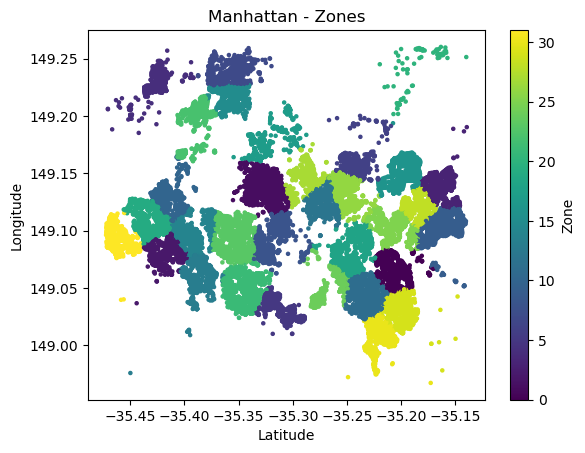

,node_id,longitude,latitude,zone_id,osm_node_id
0,1,149.206543,-35.203404,20,770347
1,2,149.214446,-35.199750,20,770350
2,3,149.251382,-35.181436,20,770373
3,4,149.140940,-35.248882,26,7987009
4,5,149.140294,-35.251121,26,7987066


In [56]:
# Step 9: Use K-Means to cluster the nodes
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

NUM_ZONES = 32

scaler = StandardScaler()
# sim_nodes_df_clean[['longitude', 'latitude']] = scaler.fit_transform(sim_nodes_df_clean[['longitude', 'latitude']])
kmeans = KMeans(n_clusters=NUM_ZONES, random_state=0).fit(sim_nodes_df_clean[['longitude', 'latitude']])
sim_nodes_df_clean['zone_id'] = kmeans.labels_

# 可视化聚类结果，不包括孤立节点
plt.scatter(sim_nodes_df_clean['latitude'], sim_nodes_df_clean['longitude'], 
            c=sim_nodes_df_clean['zone_id'], cmap='viridis', s= 5)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Manhattan - Zones')
plt.colorbar(label='Zone')
# plt.savefig(osp.join(BASEDIR, OUTPUT_NAME + '_Node_Clustering.png'),dpi=300)
plt.show()


sim_nodes_df_clean.head()

In [57]:
# Step 10: Build Graph, find the shortest path and save all_path_matrix, all_path_time_matrix
import networkx as nx
from tqdm import tqdm

# ADJ MATRIX on ZONES
# 创建网络图，并添加所有节点和边
G = nx.DiGraph()

# 添加所有节点
for node_id in sim_nodes_df_clean['node_id']:
    G.add_node(node_id)
    # add latitude and longitude
    G.nodes[node_id]['latitude'] = sim_nodes_df_clean.loc[sim_nodes_df_clean['node_id'] == node_id, 'latitude'].values[0]
    G.nodes[node_id]['longitude'] = sim_nodes_df_clean.loc[sim_nodes_df_clean['node_id'] == node_id, 'longitude'].values[0]

# 添加边
num_edges = len(sim_edge_df_clean)
arcs = tqdm(sim_edge_df_clean.iterrows(), total=num_edges, ncols=100, desc='Building network...')
for idx, arc in arcs:
    Oid = arc['from_node_id']
    Did = arc['to_node_id']
    TimeCost = arc['edge_time']
    G.add_edge(Oid, Did, TimeCost=TimeCost)

print(f'Network has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.')

# 初始化邻接矩阵
area_adjacency_matrix = np.zeros((NUM_ZONES, NUM_ZONES), dtype=int)

# 检查邻接关系
for node in sim_nodes_df_clean['node_id']:
    node_zone = sim_nodes_df_clean.loc[sim_nodes_df_clean['node_id'] == node, 'zone_id'].values[0]
    neighbors = list(G.neighbors(node))

    for neighbor in neighbors:
        neighbor_zone = sim_nodes_df_clean.loc[sim_nodes_df_clean['node_id'] == neighbor, 'zone_id'].values[0]

        # 标记不同区域间的直接相邻关系
        if node_zone != neighbor_zone and neighbor_zone != -1:
            area_adjacency_matrix[node_zone, neighbor_zone] = 1
            area_adjacency_matrix[neighbor_zone, node_zone] = 1  # 确保对称

# 添加自环
np.fill_diagonal(area_adjacency_matrix, 1)

# 输出并保存邻接矩阵
print("Area Adjacency Matrix:")
print(area_adjacency_matrix)

# # 保存邻接矩阵到CSV
# np.savetxt(osp.join(BASEDIR, OUTPUT_NAME + '_Zone_Adjacency_Matrix.csv'), area_adjacency_matrix, delimiter=",", fmt='%d')

# pickle保存
OUTPUT_PATH = 'osm/' + TARGET_CITY + '/'
OUTPUT_NAME = TARGET_CITY + '_Zone_Adjacency_Matrix.pickle'
with open(osp.join(OUTPUT_PATH + OUTPUT_NAME), 'wb') as f:
    pickle.dump(area_adjacency_matrix, f)

Building network...: 100%|███████████████████████████████| 101867/101867 [00:02<00:00, 47193.67it/s]


Network has 26565 nodes and 57904 edges.
Area Adjacency Matrix:
[[1 0 0 ... 1 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 1]
 ...
 [1 0 0 ... 1 1 0]
 [0 0 0 ... 1 1 0]
 [0 0 1 ... 0 0 1]]


In [58]:
G.nodes[2]

{'latitude': -35.1997498, 'longitude': 149.2144464}

In [63]:
# Step 11.1: Check the nodes in visualization

# Create Area adj map 
import matplotlib.colors as mcolors 
import folium 
import numpy as np 
from sklearn.cluster import KMeans 
import colorsys 
import pandas as pd 
# 准备数据为KMeans聚类 
node_coordinates = np.array([[G.nodes[node]['latitude'], G.nodes[node]['longitude']] for node in G.nodes]) 
# 执行KMeans聚类 
k = NUM_ZONES
kmeans = KMeans(n_clusters=k, random_state=0) 
cluster_labels = kmeans.fit_predict(node_coordinates) 
# 为每个节点添加zone_id属性并创建DataFrame 
nodes_data = [] 
for node, label in zip(G.nodes, cluster_labels): 
    G.nodes[node]['zone_id'] = int(label) 

# 创建高饱和度的颜色映射 
def generate_distinct_colors(n): 
    colors = [] 
    for i in range(n): 
        hue = i / n 
        saturation = 0.8 + (i % 3) * 0.1 
        value = 0.7 + (i % 2) * 0.2 
        rgb = colorsys.hsv_to_rgb(hue, saturation, value) 
        colors.append(mcolors.rgb2hex(rgb)) 
    return colors 

colors = generate_distinct_colors(k) 

# 创建Folium地图对象 
center_latitude = np.nanmean([G.nodes[node]['latitude'] for node in G.nodes])
center_longitude = np.nanmean([G.nodes[node]['longitude'] for node in G.nodes])
m = folium.Map(location=[center_latitude, center_longitude], zoom_start=12, tiles='OpenStreetMap') 

# All the edges
for edge in G.edges():
    node1, node2 = edge
    coordinates = [(G.nodes[node1]['latitude'], G.nodes[node1]['longitude']), (G.nodes[node2]['latitude'], G.nodes[node2]['longitude'])]
    folium.PolyLine(locations=coordinates, color='grey', weight=2, opacity=1).add_to(m)

# All the nodes
for node in G.nodes():
    zone_id = G.nodes[node]['zone_id']
    color = colors[zone_id]

    folium.CircleMarker(location=(G.nodes[node]['latitude'], G.nodes[node]['longitude']), radius=3, color=color, fill=True, fill_color=color, fill_opacity=1, weight=2, popup=f'Zone: {zone_id}').add_to(m)

# 保存地图 
OUTPUT_PATH = 'osm/' + TARGET_CITY + '/'
OUTPUT_NAME = TARGET_CITY + '_map_nodes.html'
m.save(osp.join(OUTPUT_PATH, OUTPUT_NAME))


In [ ]:
# Step 11.2: Check the zones in visualization

# Create Area adj map 
import matplotlib.colors as mcolors 
import folium 
import numpy as np 
from sklearn.cluster import KMeans 
import colorsys 
import pandas as pd 
# 准备数据为KMeans聚类 
node_coordinates = np.array([[G.nodes[node]['latitude'], G.nodes[node]['longitude']] for node in G.nodes]) 
# 执行KMeans聚类 
k = NUM_ZONES
kmeans = KMeans(n_clusters=k, random_state=0) 
cluster_labels = kmeans.fit_predict(node_coordinates) 
# 为每个节点添加zone_id属性并创建DataFrame 
nodes_data = [] 
for node, label in zip(G.nodes, cluster_labels): 
    G.nodes[node]['zone_id'] = int(label) 
    nodes_data.append({'node_id': node, 'latitude': G.nodes[node]['latitude'], 'longitude': G.nodes[node]['longitude'], 'zone_id': int(label)}) 

nodes_df = pd.DataFrame(nodes_data) 
# 计算每个zone的质心 
centroids = nodes_df.groupby('zone_id')[['latitude', 'longitude']].mean() 
# 创建高饱和度的颜色映射 
def generate_distinct_colors(n): 
    colors = [] 
    for i in range(n): 
        hue = i / n 
        saturation = 0.8 + (i % 3) * 0.1 
        value = 0.7 + (i % 2) * 0.2 
        rgb = colorsys.hsv_to_rgb(hue, saturation, value) 
        colors.append(mcolors.rgb2hex(rgb)) 
    return colors 

colors = generate_distinct_colors(k) 

# 创建Folium地图对象 
center_latitude = np.nanmean(centroids['latitude']) 
center_longitude = np.nanmean(centroids['longitude']) 
m = folium.Map(location=[center_latitude, center_longitude], zoom_start=12, tiles='OpenStreetMap') 

# 根据邻接矩阵绘制相邻区域之间的连线 
for i in range(k): 
    for j in range(i+1, k): 
        # 避免重复绘制对称线 
        if area_adjacency_matrix[i, j] == 1: 
            # 只画相邻区域之间的连线 
            coord1 = [centroids.loc[i, 'latitude'], centroids.loc[i, 'longitude']] 
            coord2 = [centroids.loc[j, 'latitude'], centroids.loc[j, 'longitude']] 
            folium.PolyLine( locations=[coord1, coord2], weight=5, color='gray', opacity=1 ).add_to(m) 
# 绘制质心点 
for zone_id in range(k): 
    color = colors[zone_id] 
    folium.CircleMarker( location=[centroids.loc[zone_id, 'latitude'], 
                        centroids.loc[zone_id, 'longitude']], radius=15, color=color, fill=True, fill_color=color, fill_opacity=1, weight=2, popup=f'Zone: {zone_id}' ).add_to(m) 
# 保存地图 
OUTPUT_PATH = 'osm/' + TARGET_CITY + '/'
OUTPUT_NAME = TARGET_CITY + '_map_zones_centroids.html'
m.save(osp.join(OUTPUT_PATH, OUTPUT_NAME))


In [ ]:
# Step 12: Calculate All Path Time Matrix
# Creat dijkstra_V matrix
# index start from 1
dijkstra_V = pd.DataFrame(index=sim_nodes_df_clean['node_id'], columns=sim_nodes_df_clean['node_id'])
# Fill the matrix with time cost
for i in tqdm(sim_nodes_df_clean['node_id']):
    for j in sim_nodes_df_clean['node_id']:
        try:
            dijkstra_V.loc[i, j] = nx.shortest_path_length(G, i, j, weight='TimeCost')
        except:
            dijkstra_V.loc[i, j] = np.inf

# Save all path time matrix (Efficient!)
map_dijkstra_V = copy.deepcopy(dijkstra_V).T
# add 1 to column and row
map_dijkstra_V.index = dijkstra_V.index + 1
map_dijkstra_V.columns = dijkstra_V.columns + 1

# with open(osp.join(BASEDIR,OUTPUT_NAME + '_AllPathTimeMatrix.pickle'), 'wb') as f:
#      pickle.dump(map_dijkstra_V, f)

map_dijkstra_V

  0%|          | 0/26565 [00:00<?, ?it/s]